# Quickstart Guide - Fermipy
#### https://fermipy.readthedocs.io/en/latest/quickstart.html

In [ ]:
#! curl -OL https://raw.githubusercontent.com/fermiPy/fermipy-extras/master/data/mkn421.tar.gz
#! tar xzf mkn421.tar.gz
#!cd mkn421

## Creating a Configuration File

The first step is to compose a configuration file that **defines the data selection and analysis parameters**. Complete documentation on the configuration file and available options is given in the [Configuration](https://fermipy.readthedocs.io/en/latest/config.html#config) page. fermiPy uses the [YAML format](http://yaml.org/) *(a human-friendly data serialization language for all programming languages)* for its configuration files. The configuration file has a hierarchical organization that groups related parameters into separate dictionaries. In this example we will compose a configuration file for a SOURCE-class analysis of **Markarian 421** with FRONT+BACK event types (evtype=3):

```python
data: # this section defines the input data set and spacecraft file for the analysis
  evfile : ft1.lst  # points to a list of FT1 files that encompass the chosen ROI, energy range and time selection.
  scfile : ft2.fits
  ltcube : ltcube.fits

binning: # parameters in this section define the ROI dimensions and the spatial and energy bin size 
  roiwidth   : 10.0
  binsz      : 0.1
  binsperdec : 8

selection : # this section defines parameters related to the data selection (energy range, zmax cut, and event class/type)
  emin : 100
  emax : 316227.76
  zmax    : 90        # ??
  evclass : 128
  evtype  : 3
  tmin    : 239557414
  tmax    : 428903014
  filter  : null
  target : 'mkn421' # defines the ROI center to have the same coordinates as the given source

gtlike:
  edisp : True
  irfs : 'P8R2_SOURCE_V6'
  edisp_disable : ['isodiff','galdiff']

model: # this section defines parameters related to the ROI model definition (diffuse templates, point sources).
  src_roiwidth : 15.0
  galdiff  : '$FERMI_DIFFUSE_DIR/gll_iem_v07.fits' #**
  isodiff  : 'iso_P8R2_SOURCE_V6_v06.txt'
  catalogs : ['3FGL']
```

Fermipy gives the user the option to combine multiple data selections into a joint likelihood with the _components_ section. The components section contains a **list of dictionaries with the same hierarchy as the root analysis configuration**. Each element of the list defines the analysis parameters for an independent sub-selection of the data. Any parameters not defined within the component dictionary default to the value defined in the root configuration. The following example shows the components section that could be appended to the previous configuration to **define a joint analysis with four PSF event types**:

```python
components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3
```

Any configuration parameter can be changed with this mechanism. The following example is a configuration in which a different zmax selection and isotropic template is used for each of the four PSF event types:

```python
components:
  - model: {isodiff: isotropic_source_psf0_4years_P8V3.txt}
    selection: {evtype: 4, zmax: 70}
  - model: {isodiff: isotropic_source_psf1_4years_P8V3.txt}
    selection: {evtype: 8, zmax: 75}
  - model: {isodiff: isotropic_source_psf2_4years_P8V3.txt}
    selection: {evtype: 16, zmax: 85}
  - model: {isodiff: isotropic_source_psf3_4years_P8V3.txt}
    selection: {evtype: 32, zmax: 90}
```

## Creating an Analysis Script

Once the configuration file has been composed, the analysis is executed by creating an instance of ***GTAnalysis*** with the configuration file as its argument and calling its analysis methods. ***GTAnalysis*** serves as a *wrapper* over the underlying pyLikelihood classes and **provides methods to fix/free parameters, add/remove sources from the model, and perform a fit to the ROI***.

In the following python examples we show how to initialize and run a basic analysis of a source. First we instantiate a ***GTAnalysis*** object with the path to the configuration file and run ***setup()***

The **setup()** method performs the data preparation and response calculations needed for the analysis (selecting the data, creating counts and exposure maps, etc.). Depending on the data selection and binning of the analysis this will often be the slowest step in the analysis sequence. The output of **setup()** is cached in the analysis working directory so subsequent calls to **setup()** will run much faster.

https://github.com/fermiPy/fermipy/issues/414

In [1]:
import fermipy

In [2]:
from fermipy.gtanalysis import GTAnalysis

gta = GTAnalysis('config.yaml',logging={'verbosity' : 3})







2022-07-11 01:20:21 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.1.4 
ScienceTools version 2.2.0


{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}
{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}


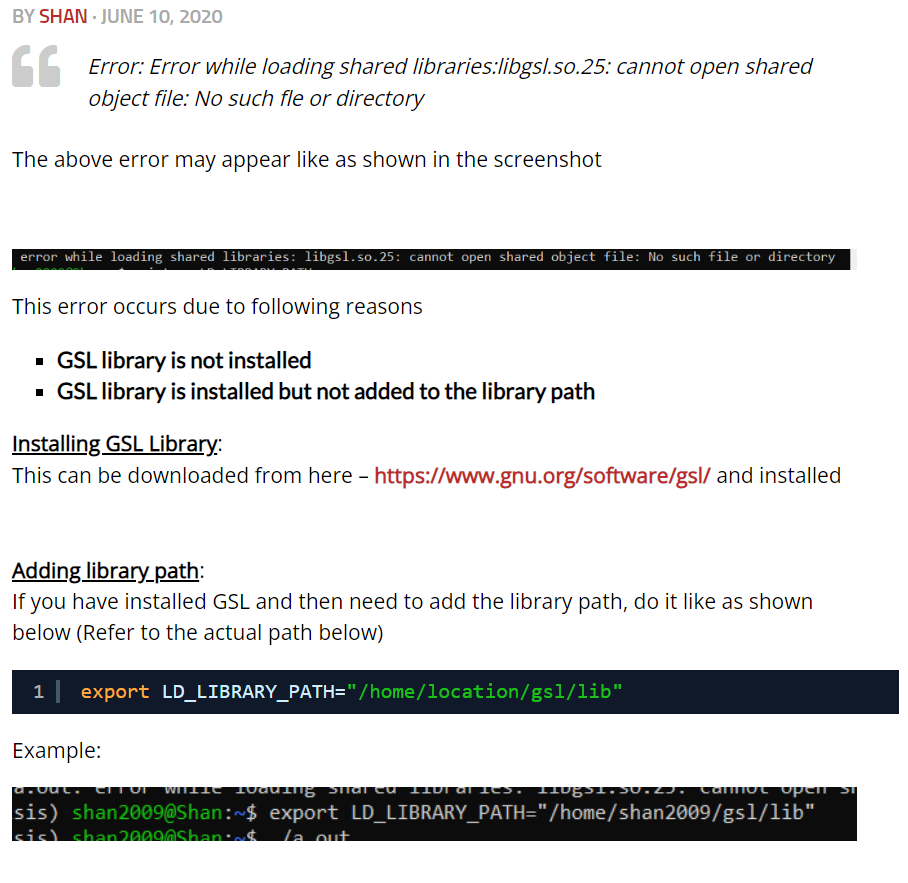

[link](https://www.ramanean.com/solved-libgsl-so-25-cannot-open-shared-object-file-no-such-fle-or-directory/)

In [3]:
gta.setup()

2022-07-11 01:20:28 INFO    GTAnalysis.setup(): Running setup.
2022-07-11 01:20:28 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2022-07-11 01:20:28 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2022-07-11 01:20:28 INFO    GTBinnedAnalysis.setup(): Using external LT cube.
2022-07-11 01:20:29 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 56874.155220 from DATE-END'. [astropy.wcs.wcs]
2022-07-11 01:20:29 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2022-07-11 01:20:29 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2022-07-11 01:20:29 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2022-07-11 01:20:37 INFO    GTAnalysis.setup(): Initializing source properties
2022-07-11 01:20:44 INFO    GTAnalysis.setup(): Finished setup.


Before running any other analysis methods it is recommended to first run ***optimize()***

In [4]:
gta.optimize()

2022-07-11 01:20:56 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['isodiff', 'galdiff', '3FGL J1104.4+3812', '3FGL J1112.4+3449', '3FGL J1127.8+3618']
Fitting shape 3FGL J1104.4+3812 TS:  87456.686
Fitting shape isodiff TS:  15535.358
Fitting shape galdiff TS:   3471.237
Fitting shape 3FGL J1120.8+4212 TS:   1087.983
Fitting shape 3FGL J1112.4+3449 TS:    948.748
Fitting shape 3FGL J1127.8+3618 TS:    796.661
Fitting shape 3FGL J1129.0+3758 TS:    204.059
Fitting shape 3FGL J1100.5+4020 TS:    159.516
Fitting shape 3FGL J1129.0+3705 TS:    111.262
Fitting shape 3FGL J1101.5+4106 TS:     84.281
Fitting shape 3FGL J1051.4+3941 TS:     83.550
Fitting shape 3FGL J1131.4+3819 TS:     51.754
Fitting shape 3FGL J1109.6+3734 TS:     42.199
Fitting shape 3FGL J1033.2+4116 TS:     31.859


2022-07-11 01:21:02 INFO    GTAnalysis.optimize(): Finished
2022-07-11 01:21:02 INFO    GTAnalysis.optimize(): LogLike: -77245.878738 Delta-LogLike: 535.222594
2022-07-11 01:21:02 INFO    GTAnalysis.optimize(): Execution time: 5.99 s


{'loglike0': -77781.10133192995,
 'loglike1': -77245.87873751752,
 'dloglike': 535.2225944124366,
 'config': {'npred_threshold': 1.0,
  'npred_frac': 0.95,
  'shape_ts_threshold': 25.0,
  'max_free_sources': 5,
  'skip': [],
  'optimizer': {'optimizer': 'MINUIT',
   'tol': 0.001,
   'max_iter': 100,
   'init_lambda': 0.0001,
   'retries': 3,
   'min_fit_quality': 2,
   'verbosity': 0}}}

This will loop over all model components in the ROI and fit their normalization and spectral shape parameters. This method also computes the TS of all sources which can be useful for identifying weak sources that could be fixed or removed from the model.

We can check the results of the optimization step by calling ***print_roi()***

In [5]:
gta.print_roi()

2022-07-11 01:21:16 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
3FGL J1104.4+3812   PointSource    PowerLaw          0.000  97712.48     31472.4
3FGL J1109.6+3734   PointSource    PowerLaw          1.204     42.45        94.6
3FGL J1100.5+4020   PointSource    PowerLaw          2.257    164.55       381.2
3FGL J1051.4+3941   PointSource    PowerLaw          2.935     85.26       208.2
3FGL J1101.5+4106   PointSource    PowerLaw          2.953     85.76       148.4
3FGL J1112.4+3449   PointSource    LogParabola       3.748   1008.04      2796.9
3FGL J1041.8+3901   PointSource    PowerLaw          4.501     22.49       129.6
3FGL J1129.0+3758   PointSource    PowerLaw          4.833    173.10       784.9
3FGL J1129.0+3705   PointSource    PowerLaw          4.997    115.07       381.3
3FGL J1127.8+3618   PointSource    PowerLaw          5.0

By default all models parameters are initially fixed. The ***free_source()*** and ***free_sources()*** methods can be use to free or fix parameters of the model. In the following example we free the normalization of catalog sources within 3 deg of the ROI center and free the galactic and isotropic components by name.

In [6]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1104.4+3812     : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1109.6+3734     : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1100.5+4020     : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1051.4+3941     : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1101.5+4106     : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']
2022-07-11 01:21:37 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Index']


The minmax_ts and minmax_npred arguments to free_sources() can be used to free or fixed sources on the basis of their current TS or Npred values:

In [7]:
# Free sources with TS > 10
gta.free_sources(minmax_ts=[10,None],pars='norm')

# Fix sources with TS < 10
gta.free_sources(minmax_ts=[None,10],free=False,pars='norm')

# Fix sources with 10 < Npred < 100
gta.free_sources(minmax_npred=[10,100],free=False,pars='norm')

2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1112.4+3449     : ['norm']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1041.8+3901     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1129.0+3758     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1129.0+3705     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1127.8+3618     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1120.8+4212     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1131.4+3819     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1033.2+4116     : ['Prefactor']
2022-07-11 01:21:50 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J110

When passing a source name argument both case and whitespace are ignored. When using a FITS catalog file a source can also be referred to by any of its associations. When using the 3FGL catalog, the following calls are equivalent ways of freeing the parameters of Mkn 421:

In [8]:
# These calls are equivalent
gta.free_source('mkn421')
gta.free_source('Mkn 421')
gta.free_source('3FGL J1104.4+3812')
gta.free_source('3fglj1104.4+3812')

2022-07-11 01:22:23 INFO    GTAnalysis.free_source(): Freeing parameters for 3FGL J1104.4+3812     : ['Index']


After freeing parameters of the model we can execute a fit by calling fit(). The will maximize the likelihood with respect to the model parameters that are currently free.


In [9]:
gta.fit()

2022-07-11 01:22:31 INFO    GTAnalysis.fit(): Starting fit.
2022-07-11 01:22:40 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2022-07-11 01:22:40 INFO    GTAnalysis.fit(): LogLike:   -77241.984 DeltaLogLike:        3.895 


{'fit_quality': 3,
 'fit_status': 0,
 'fit_success': True,
 'dloglike': 3.894640119106043,
 'edm': 0.00017847684574507033,
 'loglike': -77241.98409739841,
 'covariance': array([[ 1.38798978e-03, -1.21811349e-03, -1.21385309e-04,
          8.06741808e-05,  6.33783151e-05,  4.14348366e-05,
          1.48870316e-05,  2.34804781e-04,  4.68174216e-05,
          1.98551923e-04,  5.67065797e-06, -2.51442163e-04,
          1.52210032e-03,  1.94343370e-04, -4.66478409e-06,
         -2.75270230e-04],
        [-1.21811349e-03,  3.23778868e-01, -1.28205809e-03,
          1.25264758e-03,  7.23809073e-04,  1.26956162e-04,
          1.13440654e-05,  8.20889962e-04,  3.53735742e-04,
          6.97963903e-04,  1.76470819e-04,  2.25112061e-04,
          3.12375293e-03, -5.22928227e-04,  3.83261675e-04,
         -3.61619400e-04],
        [-1.21385309e-04, -1.28205809e-03,  4.92521630e-02,
         -8.61088614e-04,  7.25871746e-05, -1.95656175e-05,
         -8.45322166e-06,  2.88409287e-04,  1.16348486e-0

After the fitting is complete we can write the current state of the model with write_roi:


In [10]:
gta.write_roi('fit_model')

2022-07-11 01:23:05 INFO    GTBinnedAnalysis.write_xml(): Writing /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/fit_model_00.xml...
2022-07-11 01:23:05 INFO    GTAnalysis.write_fits(): Writing /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/fit_model.fits...
2022-07-11 01:23:22 INFO    GTAnalysis.write_roi(): Writing /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/fit_model.npy...


This will write several output files including an XML model file and an ROI dictionary file. The names of all output files will be prepended with the prefix argument to **write_roi()**.

*Here, the names of all output files are prepended with the prefix 'fit_model'*.

Once we have optimized our model for the ROI we can use the ***residmap()*** and ***tsmap()*** methods to assess the fit quality and look for new sources.

In [11]:
# Dictionary defining the spatial/spectral parameters of the test source
model = {'SpatialModel' : 'PointSource', 'Index' : 2.0, 'SpectrumType' : 'PowerLaw'}

# Both methods return a dictionary with the maps
m0 = gta.residmap('fit_model', model=model, make_plots=True)
m1 = gta.tsmap('fit_model', model=model, make_plots=True)

2022-07-11 01:26:33 INFO    GTAnalysis.residmap(): Generating residual maps
2022-07-11 01:26:33 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2022-07-11 01:26:34 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
/home/juliaceu14/anaconda3/envs/fermi/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
2022-07-11 01:26:38 INFO    GTAnalysis.residmap(): Finished residual maps
2022-07-11 01:26:48 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/fit_model_pointsource_powerlaw_2.00_residmap.npy
2022-07-11 01:26:48 INFO    GTAnalysis.residmap(): Execution time: 14.43 s
2022-07-11 01:26:48 INFO    GTAnalysis.tsmap(): Generating TS map
2022-07-11 01:26:48 INFO    GTAnalysi

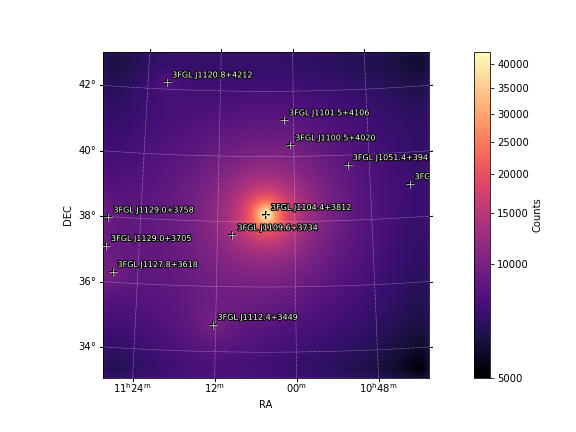

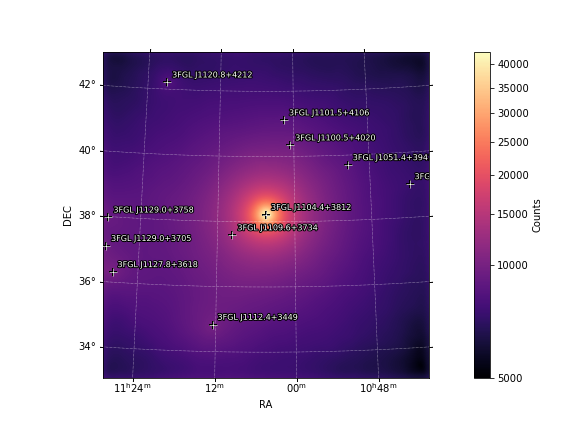

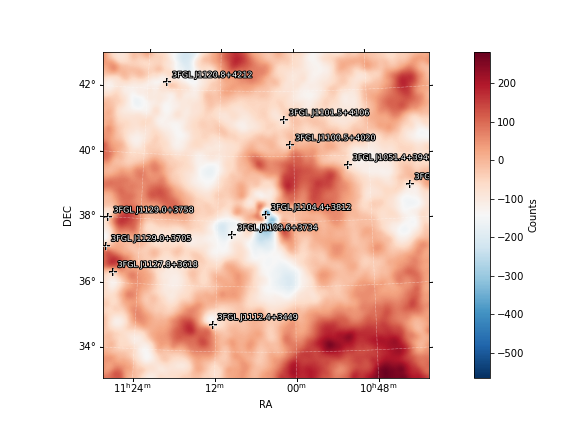

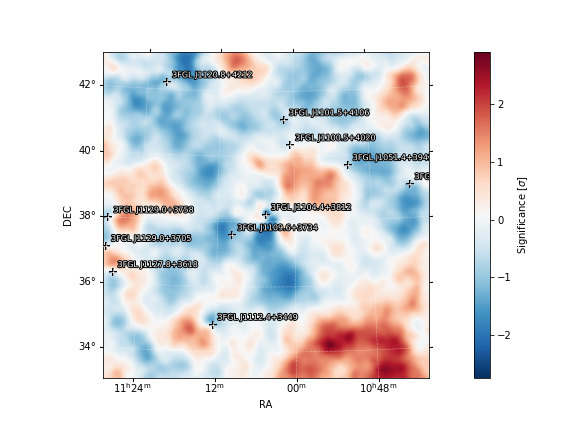

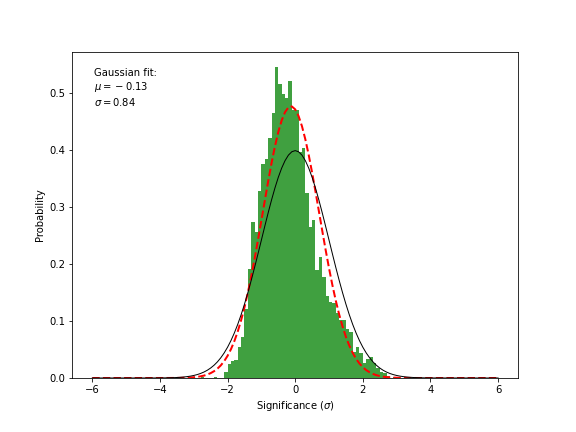

"\nImage(filename='fit_model_pointsource_powerlaw_2.00_residmap_model.png') \nImage(filename='fit_model_pointsource_powerlaw_2.00_residmap_data.png') \nImage(filename='fit_model_pointsource_powerlaw_2.00_residmap_excess.png') \nImage(filename='fit_model_pointsource_powerlaw_2.00_residmap_sigma.png') \nImage(filename='fit_model_pointsource_powerlaw_2.00_residmap_sigma_hist.png')\n"

In [41]:
from IPython.display import Image

listOfImageNames = ['fit_model_pointsource_powerlaw_2.00_residmap_model.png',
                    'fit_model_pointsource_powerlaw_2.00_residmap_data.png',
                   'fit_model_pointsource_powerlaw_2.00_residmap_excess.png',
                   'fit_model_pointsource_powerlaw_2.00_residmap_sigma.png',
                   'fit_model_pointsource_powerlaw_2.00_residmap_sigma_hist.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

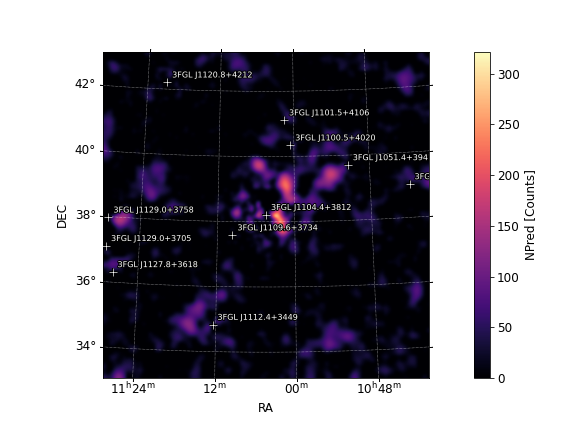

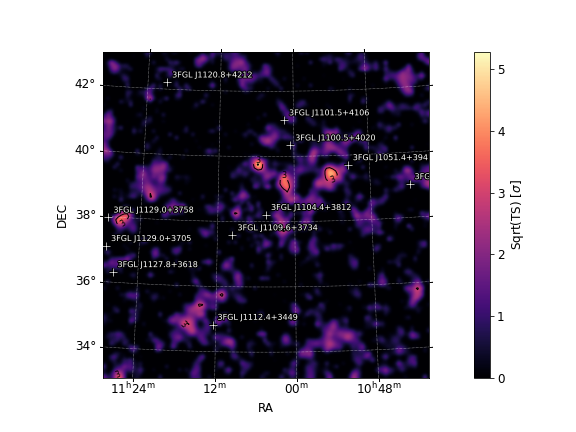

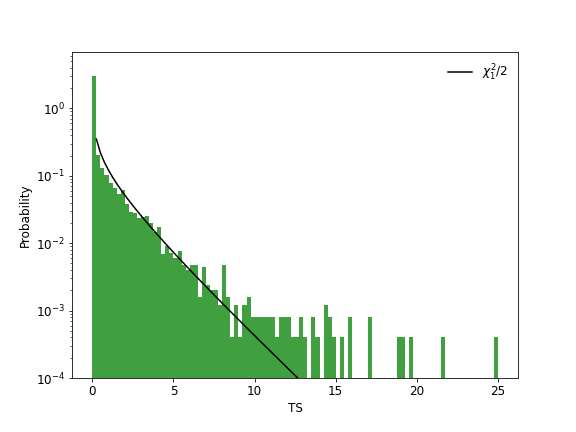

In [42]:
listOfImageNames = ['fit_model_pointsource_powerlaw_2.00_tsmap_npred.png',
                    'fit_model_pointsource_powerlaw_2.00_tsmap_sqrt_ts.png',
                   'fit_model_pointsource_powerlaw_2.00_tsmap_ts_hist.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

More documentation on these methods is available in the [TS Map](https://fermipy.readthedocs.io/en/latest/advanced/tsmap.html#tsmap) and [Residual Map](https://fermipy.readthedocs.io/en/latest/advanced/residmap.html#residmap) pages.

By default, calls to **fit()** will execute a global spectral fit over the entire energy range of the analysis. To extract a bin-by-bin flux spectrum (i.e. a SED) you can call **sed()** method with the name of the source:

*More information about sed() method can be found in the [SED Analysis page](https://fermipy.readthedocs.io/en/latest/advanced/sed.html#sed)*

In [12]:
gta.sed('mkn421', make_plots=True)

2022-07-11 01:28:30 INFO    GTAnalysis.sed(): Computing SED for 3FGL J1104.4+3812
2022-07-11 01:28:34 INFO    GTAnalysis._make_sed(): Fitting SED
2022-07-11 01:28:34 INFO    GTAnalysis.free_source(): Fixing parameters for 3FGL J1104.4+3812     : ['Index']
2022-07-11 01:28:34 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
/home/juliaceu14/.local/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2022-07-11 01:28:37 INFO    GTAnalysis.sed(): Finished SED
2022-07-11 01:28:48 INFO    GTAnalysis.sed(): Execution time: 17.27 s


{'name': '3FGL J1104.4+3812',
 'loge_min': array([2.   , 2.125, 2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ,
        3.125, 3.25 , 3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125,
        4.25 , 4.375, 4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 ,
        5.375]),
 'loge_max': array([2.125, 2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125,
        3.25 , 3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 ,
        4.375, 4.5  , 4.625, 4.75 , 4.875, 5.   , 5.125, 5.25 , 5.375,
        5.5  ]),
 'loge_ctr': array([2.0625, 2.1875, 2.3125, 2.4375, 2.5625, 2.6875, 2.8125, 2.9375,
        3.0625, 3.1875, 3.3125, 3.4375, 3.5625, 3.6875, 3.8125, 3.9375,
        4.0625, 4.1875, 4.3125, 4.4375, 4.5625, 4.6875, 4.8125, 4.9375,
        5.0625, 5.1875, 5.3125, 5.4375]),
 'loge_ref': array([2.0625, 2.1875, 2.3125, 2.4375, 2.5625, 2.6875, 2.8125, 2.9375,
        3.0625, 3.1875, 3.3125, 3.4375, 3.5625, 3.6875, 3.8125, 3.9375,
        4.0625, 4.1875, 4.3125, 4.4375, 4.5625, 4.6875, 4.81

## Extracting Analysis Results

Results of the analysis can be extracted from the dictionary file written by **write_roi()**. This method writes information about the current state of the analysis to a python dictionary. More documentation on the contents of the output file are available in the [Output File page](https://fermipy.readthedocs.io/en/latest/output.html#output).

By default the output dictionary is written to a file in the [numpy format](http://docs.scipy.org/doc/numpy/neps/npy-format.html) and can be loaded from a python session after your analysis is complete. The following demonstrates how to load the analysis dictionary that was written to *fit_model.npy* in the Mkn421 analysis example:

In [20]:
# Load analysis dictionary from a npy file
import numpy as np
c = np.load('fit_model.npy', allow_pickle=True).flat[0]
list(c.keys())

['roi', 'config', 'version', 'stversion', 'sources', 'lck_params']

The output dictionary contains the following top-level elements:

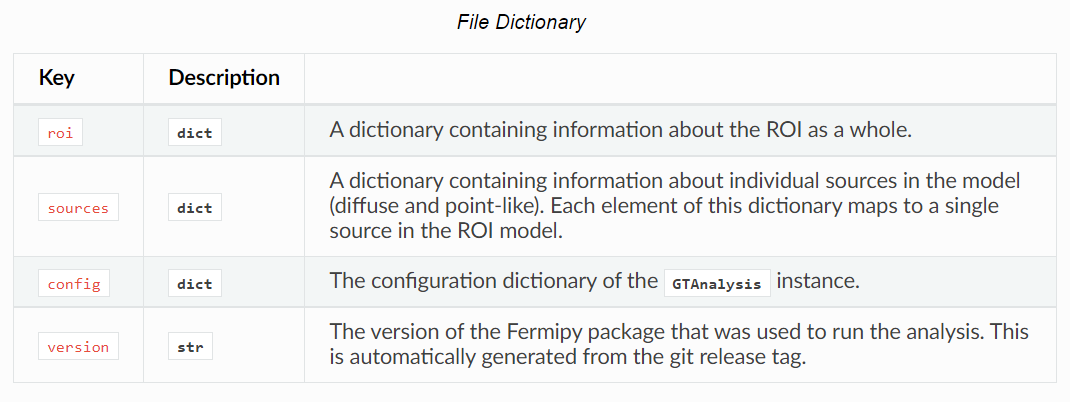

Each source dictionary collects the properties of the given source (TS, NPred, best-fit parameters, etc.) computed up to that point in the analysis.

In [23]:
list(c['sources'].keys())

['3FGL J1104.4+3812',
 '3FGL J1109.6+3734',
 '3FGL J1100.5+4020',
 '3FGL J1051.4+3941',
 '3FGL J1101.5+4106',
 '3FGL J1112.4+3449',
 '3FGL J1041.8+3901',
 '3FGL J1129.0+3758',
 '3FGL J1129.0+3705',
 '3FGL J1127.8+3618',
 '3FGL J1120.8+4212',
 '3FGL J1131.4+3819',
 '3FGL J1105.7+4427',
 '3FGL J1032.7+3735',
 '3FGL J1033.2+4116',
 '3FGL J1136.4+3405',
 '3FGL J1145.8+4425',
 'isodiff',
 'galdiff']

In [22]:
c['sources']['3FGL J1104.4+3812']['ts']
#87455.9709683

88289.15267969875

In [24]:
c['sources']['3FGL J1104.4+3812']['npred']
#31583.7166495

31450.54012417882

Information about individual sources in the ROI is also saved to a catalog FITS file with the same string prefix as the dictionary file. This file can be loaded with the **astropy.io.fits** or **astropy.table.Table** interface:

In [30]:
# Load the source catalog file
from astropy.table import Table
tab = Table.read('fit_model.fits', hdu=1)
tab[['name','class','ts','npred','flux']]

name,class,ts,npred,flux
,,,,1 / (cm2 s)
bytes48,bytes32,float64,float64,float64
3FGL J1104.4+3812,BLL,88289.153,31450.540,0.000
3FGL J1109.6+3734,bll,42.449,94.613,0.000
3FGL J1100.5+4020,bll,168.788,390.333,0.000
3FGL J1051.4+3941,bll,87.270,210.897,0.000
3FGL J1101.5+4106,bll,87.919,150.090,0.000
3FGL J1112.4+3449,fsrq,947.099,2816.018,0.000
3FGL J1041.8+3901,bll,23.394,131.440,0.000
3FGL J1129.0+3758,--,153.822,750.867,0.000


The FITS file contains columns for all scalar and vector elements of the source dictionary. Spectral fit parameters are contained in the **param_names**, **param_values**, and **param_errors** columns:

In [33]:
tab[['param_names','param_values','param_errors']][0]

param_names,param_values,param_errors
bytes32[10],float64[10],float64[10]
Prefactor .. --,2.1307476556867442e-11 .. --,1.6227290598702024e-13 .. --


## Reloading from a Previous State

One can reload an analysis instance that was saved with **write_roi()** by calling either the **create()** or **load_roi()** methods. The **create()** method can be used to construct an entirely new instance of GTAnalysis from a previously saved results file:

In [34]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis.create('fit_model.npy')

# Continue running analysis starting from the previously saved state
gta.fit()

2022-07-11 01:51:40 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.1.4 
ScienceTools version 2.2.0


{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}


2022-07-11 01:51:41 INFO    GTAnalysis.setup(): Running setup.
2022-07-11 01:51:41 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2022-07-11 01:51:41 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2022-07-11 01:51:41 INFO    GTBinnedAnalysis.setup(): Using external LT cube.


{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}


2022-07-11 01:51:42 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 56874.155220 from DATE-END'. [astropy.wcs.wcs]
2022-07-11 01:51:42 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2022-07-11 01:51:42 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2022-07-11 01:51:42 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2022-07-11 01:51:51 INFO    GTAnalysis.setup(): Finished setup.
2022-07-11 01:51:51 INFO    GTAnalysis.load_roi(): Loading ROI file: /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/fit_model.npy
2022-07-11 01:51:51 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2022-07-11 01:51:59 INFO    GTAnalysis.load_roi(): Finished Loading ROI
2022-07-11 01:51:59 INFO    GTAnalysis.fit(): Sta

{'fit_quality': 3,
 'fit_status': 0,
 'fit_success': True,
 'dloglike': 8.502995478920639e-05,
 'edm': 8.499214217336357e-06,
 'loglike': -77241.98401237,
 'covariance': array([[ 1.38770533e-03, -1.21818161e-03, -1.21400942e-04,
          8.06048761e-05,  6.33296475e-05,  4.14202586e-05,
          1.48828648e-05,  2.34768915e-04,  4.68065067e-05,
          1.98547825e-04,  5.68504415e-06, -2.50909210e-04,
          1.52105740e-03,  1.94165492e-04, -4.75339430e-06,
         -2.75047031e-04],
        [-1.21818161e-03,  3.23836026e-01, -1.28240313e-03,
          1.25253135e-03,  7.23765477e-04,  1.26961690e-04,
          1.13435811e-05,  8.21044064e-04,  3.53762905e-04,
          6.98151563e-04,  1.76507667e-04,  2.25849627e-04,
          3.12313285e-03, -5.23275422e-04,  3.83024775e-04,
         -3.61246971e-04],
        [-1.21400942e-04, -1.28240313e-03,  4.92499044e-02,
         -8.61047915e-04,  7.25344745e-05, -1.95602899e-05,
         -8.45320992e-06,  2.88424700e-04,  1.16343792e-0

where the argument is the path to an output file produced with **write_roi()**. This function will instantiate a new analysis object, run the **setup()** method, and load the state of the model parameters at the time that **write_roi()** was called.

The **load_roi()** method can be used to reload a previous state of the analysis to an existing instance of GTAnalysis.

In [35]:
from fermipy.gtanalysis import GTAnalysis

gta = GTAnalysis('config.yaml')
gta.setup()

gta.write_roi('prefit_model')

# Fit a source
gta.free_source('mkn421')
gta.fit()

# Restore the analysis to its prior state before the fit of mkn421
# was executed
gta.load_roi('prefit_model')

2022-07-11 01:53:38 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.1.4 
ScienceTools version 2.2.0


{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}


2022-07-11 01:53:39 INFO    GTAnalysis.setup(): Running setup.
2022-07-11 01:53:39 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2022-07-11 01:53:39 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2022-07-11 01:53:39 INFO    GTBinnedAnalysis.setup(): Using external LT cube.


{'Prefactor': 0, 'Index1': 1, 'Scale': 2, 'Cutoff': 3, 'Index2': 4}


2022-07-11 01:53:40 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 54682.655283 from DATE-OBS.
Set MJD-END to 56874.155220 from DATE-END'. [astropy.wcs.wcs]
2022-07-11 01:53:40 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2022-07-11 01:53:40 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2022-07-11 01:53:40 INFO    GTBinnedAnalysis._create_binned_analysis(): Creating BinnedAnalysis for component 00.
2022-07-11 01:53:48 INFO    GTAnalysis.setup(): Initializing source properties
2022-07-11 01:53:49 INFO    GTAnalysis.setup(): Finished setup.
2022-07-11 01:53:49 INFO    GTBinnedAnalysis.write_xml(): Writing /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/prefit_model_00.xml...
2022-07-11 01:53:49 INFO    GTAnalysis.write_fits(): Writing /mnt/c/Users/Julia/Documents/astrophysics-IC/Fermipy Quickstart Guide/mkn421/prefit_model

Using **load_roi()** is generally faster than **create()** when an analysis instance already exists.